In [1]:
# import librairies
import numpy as np
import scipy.io as sio
from scipy.stats import beta
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# construct two classes of probability density functions (PDFs) from beta distributions
a1, b1 = 2, 2 # parameters of class 1 
a2, b2 = 1.8, 2 # parameters of class 2

In [3]:
# define inputs (time instances)
d=100 # fix the number of points per PDF
t = np.linspace(0,1, d) 

In [4]:
Nsimulations=500 # fix the number of observations per class
p1=np.zeros([Nsimulations,d]) # initialize the first class
p2=np.zeros([Nsimulations,d]) # initialize the second class
for i in range(Nsimulations):
    p1[i,:]=beta.pdf(t, a1+np.random.uniform(-0.2,0.2), b1) # PDFs of the first class
    p2[i,:]=beta.pdf(t, a2+np.random.uniform(-0.2,0.2), b2) # PDFs of the second class

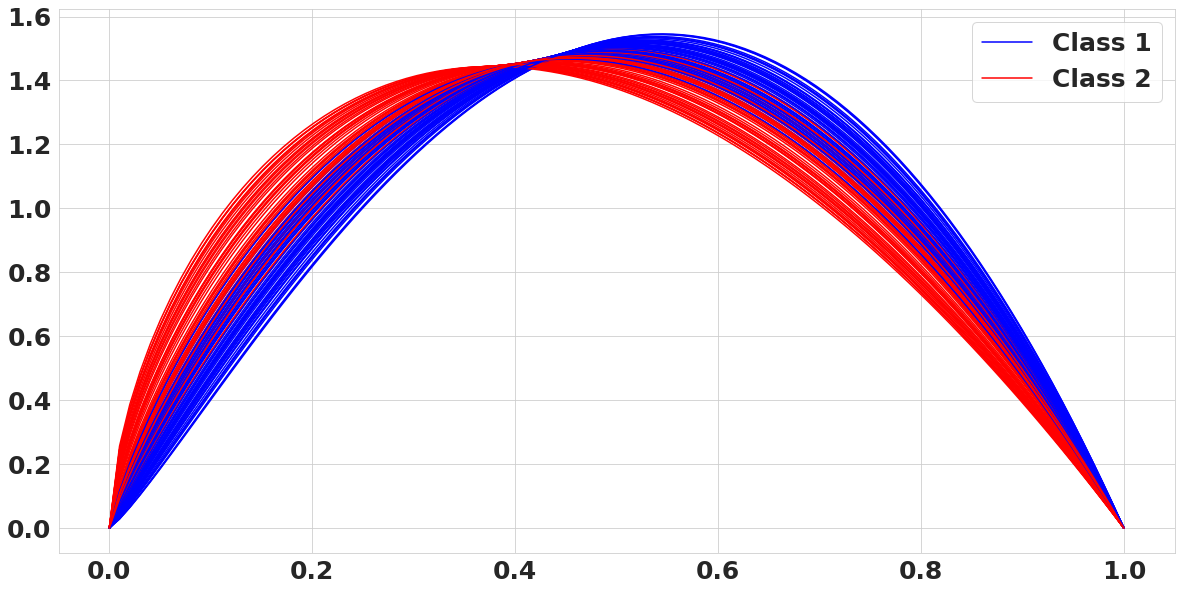

In [5]:
# plot some examples of PDFs
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 25})
plt.rcParams.update({'legend.fontsize': 25})
plt.rcParams['font.weight'] = 'bold'

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)

for j in range(50):
    plt.plot(t,p1[j,:],color='b',label="Class 1")
    plt.plot(t,p2[j,:],color='r',label="Class 2")
    
ax.legend(['Class 1', 'Class 2'], loc='best')

plt.show()

In [6]:
# find the corresponding square-root density functions (SRDFs) 
psi1=np.sqrt(p1); psi2=np.sqrt(p2)

In [7]:
# fix the truncation order
m=50 

In [8]:
# define the basis function in [0,1]
def basis(m,x):
    d=t.shape[0]
    Phi=np.zeros([m,d])
    for i in range(m):
        for j in range(d):
            Phi[i,j]=np.sqrt(2)*np.sin(np.pi*(i+1)*x[j])
    return Phi 

In [9]:
# evaluate the basis function for all time instances t
Phi=basis(m,t)

In [10]:
# get spherical coefficients of size m and belonging to S^{m-1}
X1=np.zeros([p1.shape[0],m]); X2=np.zeros([p2.shape[0],m])
for i in range(p1.shape[0]):
    for j in range(m):
        X1[i,j]=-np.trapz(t,psi1[i,:]*Phi[j,:])

for i in range(p2.shape[0]):
    for j in range(m):
        X2[i,j]=-np.trapz(t,psi2[i,:]*Phi[j,:])

In [11]:
X=np.concatenate((X1,X2)) # concatenate all spherical coefficients together

In [12]:
# compute the Fréchet mean estimate of spherical coefficients
from geomstats.learning.frechet_mean import FrechetMean
from geomstats.geometry.hypersphere import Hypersphere
sphere = Hypersphere(dim=m-1)   
Fmean = FrechetMean(metric=sphere.metric)
Fmean.fit(X)
estimate_mean=Fmean.estimate_

INFO: Using numpy backend
/home/nash/snap/jupyter/common/lib/python3.7/site-packages/joblib/_multiprocessing_helpers.py:53: UserWarning: [Errno 13] Permission denied.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


In [13]:
# map the spherical coefficients to the tangent space at the Fréchet mean
n=p1.shape[0]+p2.shape[0];
x=np.zeros([n,m]);  
for i in range(n):
    x[i,:]=X[i,:]/np.inner(np.array(X[i,:]),estimate_mean.T)
x.shape # check dimensions

(1000, 50)

In [14]:
# construct the binary vector of outputs 0/1 
y = np.vstack((np.ones((p1.shape[0], 1)),np.zeros((p2.shape[0], 1))))
y.shape # check dimension

(1000, 1)

In [15]:
# import the sklearn library 
import sklearn as sk
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

In [16]:
# results of the GP classifier applied to projected coefficients 
import random

gp_opt = GaussianProcessClassifier(kernel=1.0 * RBF(length_scale=1.0)) # fix the class of kernel 

ind=random.sample(range(0, n), int(3*n/4))
index=np.isin(range(0, n), ind) # random split with 75% for training and 25% for test

xtrain=x[index] # training input 
ytrain=y[index] # training output
xtest=x[~index] # test input
ytest=y[~index] # test output
    
gp_opt.fit(xtrain, ytrain) # learn the GP classifier

NMLL=-gp_opt.log_marginal_likelihood(gp_opt.kernel_.theta) # negative marginal log-likelihood

ACC=accuracy_score(ytest, gp_opt.predict(xtest)) # accuracy score

AUC=roc_auc_score(ytest, gp_opt.predict_proba(xtest)[:, 1]) # AUC criteria
        
LOSS=log_loss(ytest, gp_opt.predict_proba(xtest)[:, 1]) # loss measure
    

/home/nash/snap/jupyter/common/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [17]:
print(gp_opt.kernel_) # display the optimal kernel parameters

19**2 * RBF(length_scale=0.0259)


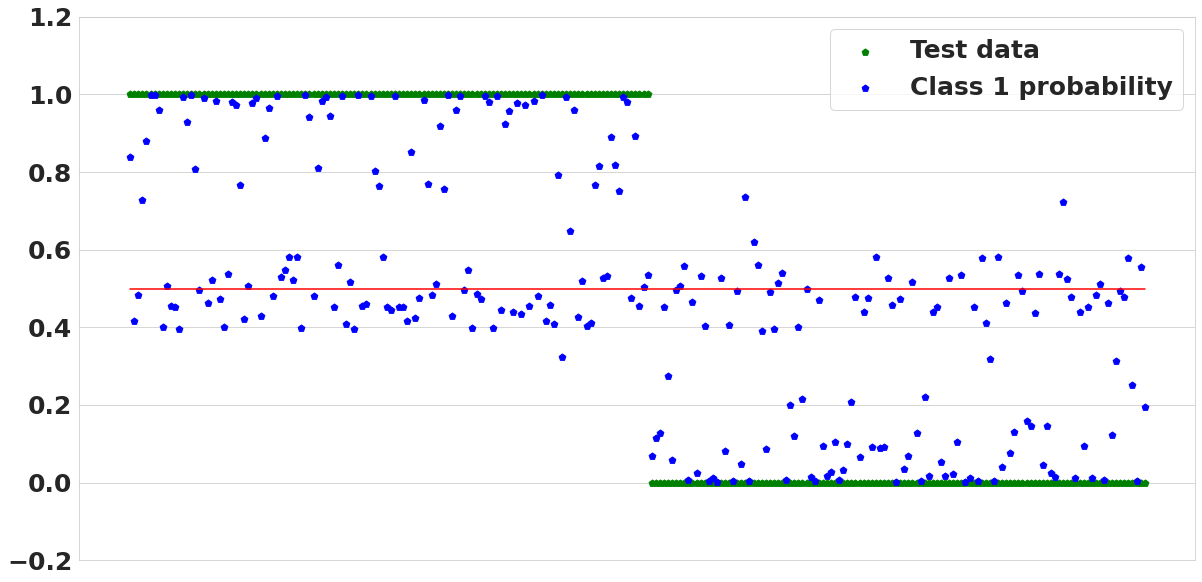

In [18]:
# plot the class 1 probability with test data together
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 25})
plt.rcParams.update({'legend.fontsize': 25})
plt.rcParams['font.weight'] = 'bold'

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)

plt.scatter(range(1,ytest.shape[0]+1) , ytest, s=50,color='g', marker=(5, 0), label="Test data")
plt.scatter(range(1,ytest.shape[0]+1),gp_opt.predict_proba(xtest)[:, 1],s=50,color='b', marker=(5, 0),label="Class 1 probability")
plt.plot([1, ytest.shape[0]],[0.5, 0.5],c="r")

plt.ylim(-0.2, 1.2)
plt.legend(loc="best")
plt.xticks([])
plt.show()

In [19]:
# Apply PCA to the coefficients on the tangent space of the sphere (TPCA) for illustration
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
pca.fit(x)
z=pca.transform(x)
print(z.shape)
print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))

(1000, 1)
[0.99788524]
0.9978852395089017


/snap/jupyter/6/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


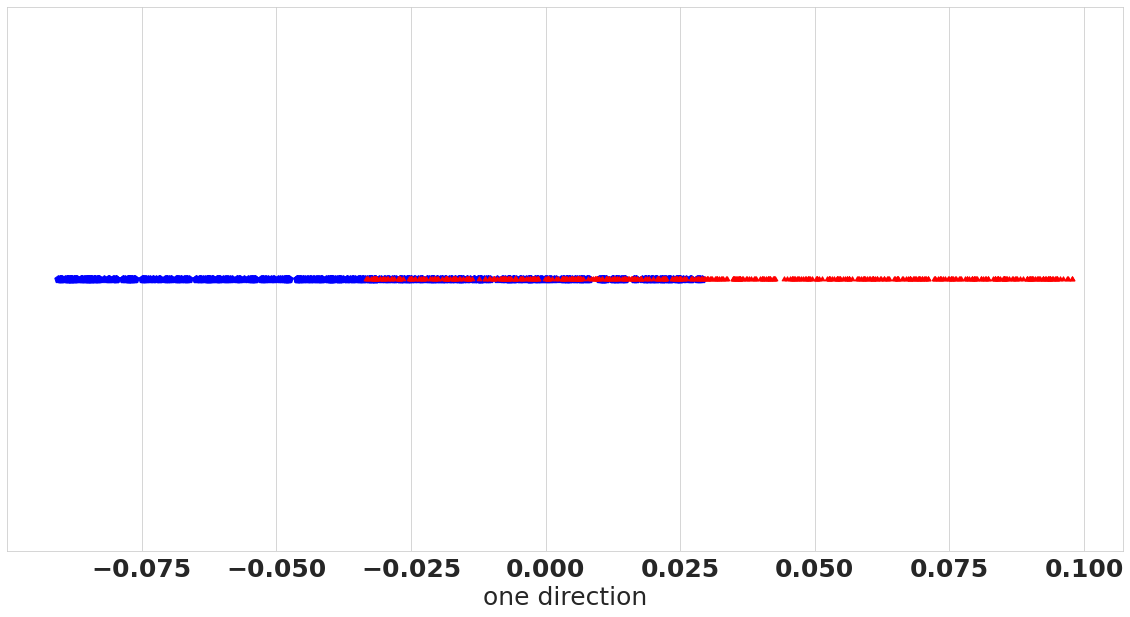

In [20]:
# plot projected coefficients into one direction
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 25})
plt.rcParams.update({'legend.fontsize': 25})
plt.rcParams['font.weight'] = 'bold'

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)

plt.scatter( z[0:p1.shape[0]], [0] * z[0:p1.shape[0]].shape[0],s=60,color='b', marker=(5, 0))
plt.scatter( z[p1.shape[0]:np.int(n)], [0] * z[p1.shape[0]:np.int(n)].shape[0],s=30,color='r', marker=(3, 0))

plt.xlabel("one direction")
plt.yticks([])

plt.show()